# Time Series Prediction

In this notebook we are going to look at time series. Time series is a special class of data where the data is ordered and past values should be used to predict future - there is a temporal ordering. We will begin with a very simple data set but one that is an easy example to work with before moving to real problems.

**Summary**
- [Linear Autoregressive Models](#ar)
- [Local Constant Models](#lm)
- [Nonlinear Global Models](#nonlinear)

In [1]:
import numpy as np  # written in C, is faster and robust library for numerical and matrix operations
import math #provides access to the mathematical functions defined by the C standard.
import pandas as pd # data manipulation library, it is widely used for data analysis and relies on numpy library.
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # plot nicely =)

%matplotlib inline

## Reading Sunspot Dataset

In [2]:
df = pd.read_csv('../data/sunspots.dat', header=None, delimiter=' ', 
                 usecols=[2,4])
df.columns = ['year', 'sunspots']
df.year = df.year.astype(np.int64)
df.head()

,year,sunspots
0,1700,5.0
1,1701,11.0
2,1702,16.0
3,1703,23.0
4,1704,36.0


### Visualising the Data

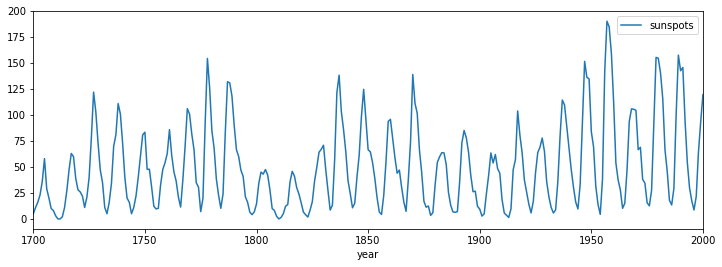

In [3]:
_ = df.plot(x='year', y='sunspots', figsize=(12,4))

## Linear Autoregressive Models (AR)
<a id='ar'></a>

Here we will implement from scratch the Linear Autoregressive Models and hopefully be able to forecast the sunspots for the next years.

**Summary:**
 - [Fitting the Model](#ar_t)
 - [Forecasting](#ar_f)

### Fitting the Model 
<a id='ar_t'></a>

This step consists in the estimation of the parameters $\hat{A}$ by solving the following system:

$$
\overbrace{\begin{bmatrix}
    x_{1}  & x_{2}  & \dots & x_{d} \\
    x_{2}  & x_{3}  &\dots & x_{d+1} \\
    \vdots  &  \vdots & \ddots & \vdots \\
    x_{n-d+1}  & x_{n-d+2} & \dots & x_{n}
\end{bmatrix}}^{X} 
\overbrace{\begin{bmatrix}
    \alpha_{1} \\
    \alpha_{2}  \\
    \vdots \\
    \alpha_{d} 
\end{bmatrix}}^{A}
\approx
\overbrace{\begin{bmatrix}
    x_{d+1} \\
    x_{d+2}  \\
    \vdots \\
    x_{n+1} 
\end{bmatrix}}^{y}$$

$A$ is estimated as follows:
$$\hat{A} = X^{-1}y$$

Note that $X$ is generally a rectangular matrix ($d$ is usually much smaller than the number of rows of $X$), so we can't compute its inverse. Thus we are going to compute the (Moore-Penrose) pseudo-inverse of X. This is done by using the function [np.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html).

In [4]:
def AR(data, maxlag = 1):
    """
    Implements Autoregression (AR) 
    parameters:
        data: times series data
        maxlag: degree of the model (1 by default)
    return:
        X, y and b (A hat)
    """
    #linear model of order max lag 8)
    #data = df['sunspots'].values
    maxz = data.size  #to separete test and fit data, this should be reduced

    # Computing matrix X
    X = np.array([data[i:(maxz-maxlag-1)+i] for i in range(0, maxlag)])
    # Performing the transponse of X
    X = X.T

    # Computing matrix y
    y = np.array(data[maxlag+1:maxz])

    # Computing the Pseudo-Inverse of X (as X is a rectangular matrix)
    Xinv = np.linalg.pinv(X.copy())
    
    # Solving the linear system b = Xinv * y
    b = np.dot(Xinv, y)
    
    return (X, y, b)

In [5]:
maxlag = 2
X, y, b = AR(df.sunspots.values, maxlag)

print('Estimated Â: {}'.format(b))

Estimated Â: [-0.80101254  1.53150606]


### Predictions
<a id='ar_f'></a>

Given the $b$ (Â), we can perform predictions as:

$$y_p = X*b$$

Let's first check how $y_p$ looks like when $X$ (original data) is used, and then let's implement the [pred_ar](#pre_ar) function for prediction in the following.

In [6]:
yp = np.dot(X, b)

#### Comparing the $y_p$ against $y$

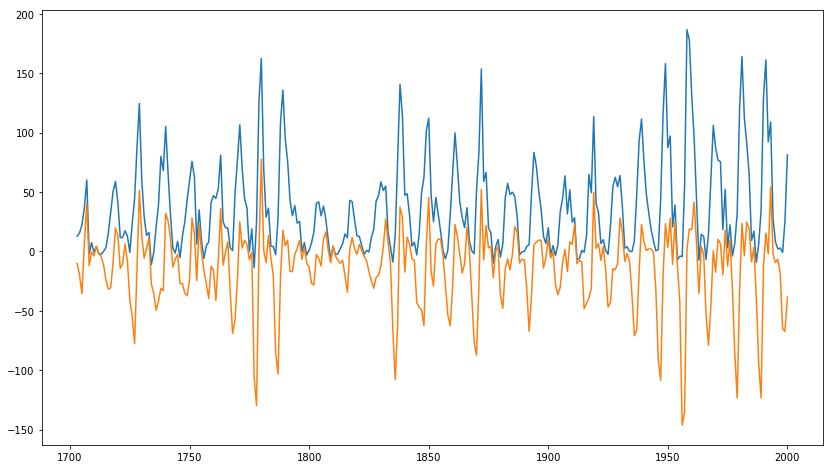

In [7]:
plt.figure(figsize=(14,8))
plt.plot(df.year[maxlag+1:], yp)
plt.plot(df.year[maxlag+1:], yp - y)

In [8]:
def pred_ar(data, b, maxlag = 1, nstep = 100):
    """
    Implements yp = xi * b to predict nsteps
    parameters:
        data: times series data
        b: estimated parameters
        maxlag: degree of the model (1 by default)
        nstep: number of steps (100 by default)
    return:
        predicted values
    """
        
    xinit = data[-maxlag-1:-1]
    xi = xinit
    step = 0
    yp = data[-1]

    while step < nstep:
        xp = xi.dot(b) # past observation xi * b
        xi = np.delete(xi,0)
        xi = np.append(xi,xp)
        yp = np.append(yp,xp)
        
        step += 1
        
    return yp

In [9]:
nstep = 50
yp = pred_ar(df.sunspots.values, b, maxlag, nstep)

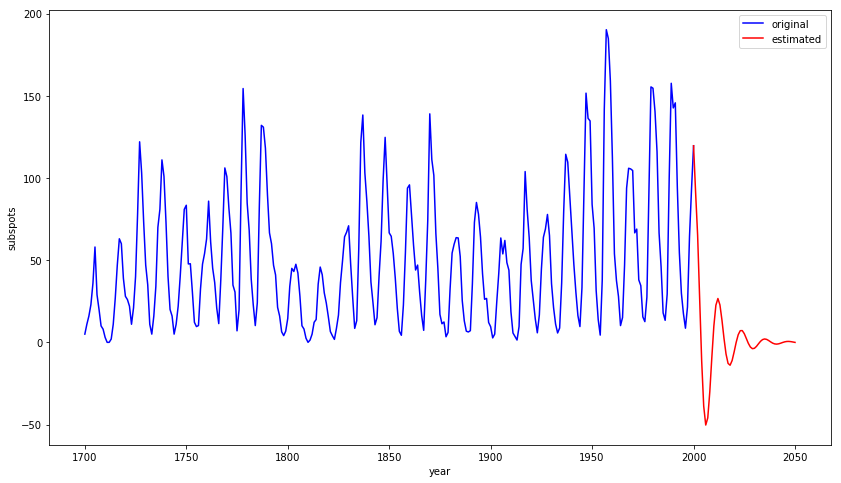

In [10]:
# Visualising the Predictions
years = [year for year in range(df.year.values[-1], df.year.values[-1]+nstep+1)]

plt.figure(figsize=(14,8))
plt.plot(df.year, df.sunspots, c='b', label='original')
plt.plot(years, yp, c='r', label='estimated')
plt.xlabel('year')
plt.ylabel('subspots')
plt.legend()
plt.show()

Predicting the next 1000 years.

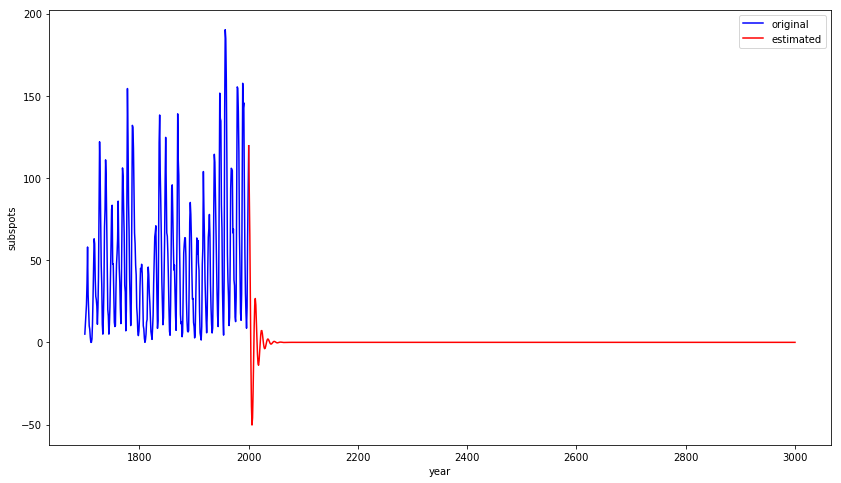

In [11]:
nstep=1000
yp = pred_ar(df.sunspots.values, b, maxlag, nstep)

# Visualising the Predictions
years = [year for year in range(df.year.values[-1], df.year.values[-1]+nstep+1)]

plt.figure(figsize=(14,8))
plt.plot(df.year, df.sunspots, c='b', label='original')
plt.plot(years, yp, c='r', label='estimated')
plt.xlabel('year')
plt.ylabel('subspots')
plt.legend()
plt.show()

## Local Constant Models
<a id='lm'></a>

*"Local models generate predictions by finding local portions of the time series that closely resemble a portion of the points immediately preceding the point to be predicted. The prediction is an estimate of the average change that occurred immediately after these similar portions of points"* ([A Nearest Trajectory Strategy for Time Series Prediction](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.296.5108&rep=rep1&type=pdf)). 

Two main steps are considered in this approach:
 - **Embedding**: embed the data using Takens theorem.  
 - **Use successors of near-neighbours as predictors**. it requires the use of a distance metric to find neighbors. Here we use the Euclidean Distance. 
 
The algorithm for Local Modelling is given by the following steps:
  1. Compute the distance to the points $x_i$  with respect to $X$
  2. Sort the distances
  3. Find the second smallest value to predict the true future
  4. Repeat steps 1, 2 and 3 for all the step (years)

You will note that we don't necessarily need to sort the entire distance matrix. Remember that we are only interested in the **k** nearest neighbours. In practice, we can use the [np.argpartition](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.argpartition.html) function, which performs a partition of the dataset considering only the **k+1** neighbours. A detailed explanation about the function can be found in this book: [Python Data Science Handbook by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.08-sorting.html). 

In [12]:
def pred_local_constant_model(data, X, y, maxlag = 1, nstep = 100):
    """
    Implements yp = xi * b to predict nsteps
    parameters:
        data: times series data
        X: data representation
        y: value of the function for each row in X
        maxlag: degree of the model (1 by default)
        nstep: number of steps (100 by default)
    return:
        predictions
    """
        
    #now free-rn from a local constant model
    xinit = data[-maxlag-1:-1]
    xi = xinit
    step = 0
    yp = data[-1]

    #distance function
    dist = lambda x1, x2: math.sqrt(((x1-x2)**2).sum())

    while step < nstep:
        # 1) Compute the distance to the points xi with respect X
        xdm = [dist(xi,xj) for xj in X]
        
        # 2) Sort the distances, rather neat way of finding the second 
        #    smallest without doing a full sort
        ind = np.argpartition(xdm,2)[2]
        # 3) Find the second smallest value to predict the true future
        xp = y[ind]
        
        # update xi and yp
        xi = np.delete(xi,0)
        xi = np.append(xi,xp)
        yp = np.append(yp,xp)
        
        # increment and repeat steps 1, 2 and 3 until step == nstep
        step += 1
        
    return yp

Using the function *pred_local_constant_model* to predict the future.

In [13]:
nsteps = 100 # predict the next 100 years
yp2= pred_local_constant_model(df.sunspots.values, X, y, maxlag, nsteps)

### Visualising the Predictions

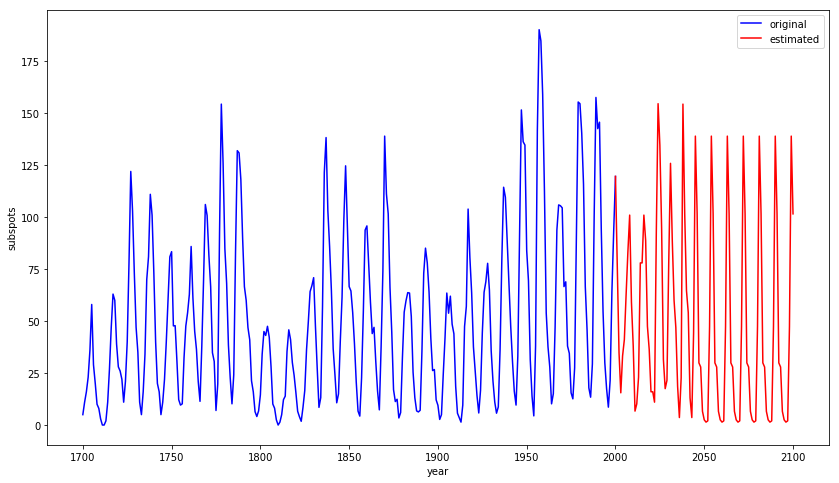

In [14]:
# Visualising the Predictions
years = [year for year in range(df.year.values[-1], df.year.values[-1]+nsteps+1)]

plt.figure(figsize=(14,8))
plt.plot(df.year, df.sunspots, c='b', label='original')
plt.plot(years, yp2, c='r', label='estimated')
plt.xlabel('year')
plt.ylabel('subspots')
plt.legend()
plt.show()

## Nonlinear Global Models
<a id='nonlinear'></a>

### Fitting the Model 
<a id='ar_t'></a>

Similar as before, in this step we estimate the parameters $\hat{A}$ by solving the following system:

$$\overbrace{\begin{bmatrix}
    \phi_{1}  & \phi_{2}  & \dots & \phi_{d} \\
    \phi_{2}  & \phi_{3}  &\dots & \phi_{d+1} \\
    \vdots  &  \vdots & \ddots & \vdots \\
    \phi_{n-d+1}  & \phi_{n-d+2} & \dots & \phi_{n}
\end{bmatrix}}^{\Phi} 
\overbrace{\begin{bmatrix}
    \alpha_{1} \\
    \alpha_{2}  \\
    \vdots \\
    \alpha_{d} 
\end{bmatrix}}^{A}
\approx
\overbrace{\begin{bmatrix}
    x_{d+1} \\
    x_{d+2}  \\
    \vdots \\
    x_{n+1} 
\end{bmatrix}}^{y}$$

$A$ is estimated as follows:
$$\hat{A} = \Phi^{-1}y$$

Again, we are going to apply the (Moore-Penrose) pseudo-inverse in $\Phi$, similar to [Autoregression](#ar_t) case.

Note that now we apply the same idea from the linear model - but generate a (larger) set of nonlinear candidates, in this case, all polynomial combinations of the variables up to order **polyk=3**.

### First, let's define the non-linear function ($\Phi$).

In [15]:
#(WARNING - there will be (maxlag+1)**polyk of these !)
# the following construction is (perhaps) a little prosaic and not central to the point of this lesson
def non_linear_function(X):
    """
    Implements the polynomial basis, we'll just to up to order three here - 
    the rest is an "exercise for the reader"
    parameters:
        X: data
    return:
        Non-linear function
    """
    Xtl=X.transpose().tolist() 
    Xtl.insert(0,1)  #prepend xtl with a 1
    Phi = [np.array(xi)*np.array(xj)*np.array(xk) for xi in Xtl 
                                                    for xj in Xtl 
                                                      for xk in Xtl 
                                                        if Xtl.index(xi) >= Xtl.index(xj) >= Xtl.index(xk) ]
    Phi.pop(0)
    Phi=np.array(Phi)
    Phi=Phi.transpose() #xp is now the desired numpy array constructed by multipling columns of X together 
    
    return Phi

In [16]:
Phi = non_linear_function(X)
Phi.shape

(298, 9)

Now we just repeat the previous linear model steps, in other words,
 
$$\hat{A} = \Phi^{-1}y$$

In [17]:
def nonlinear_global_models(Phi, y):
    """
    Estimates A hat
    parameters:
        Phi: non linear basis
        y: value of the function for each Phi
    return:
        Estimated A
    """
    
    Phi_inv = np.linalg.pinv(Phi.copy())
    
    return np.dot(Phi_inv,y)

In [18]:
# y was already computed before using the AR function
b = nonlinear_global_models(Phi, y)
print(b)

[-1.42054174e+00  2.34896278e-02 -3.01444885e-05  3.45936065e+00
 -4.15690938e-02 -5.41196741e-05 -8.56977830e-03  2.15951309e-04
 -2.02556571e-05]


**Your turn**

In this exercise we propose that you apply these concepts in "real data".

In [19]:
# Loading the data
df = pd.read_csv('../data/gas-furnace.csv')
df.head()

,InputGasRate,CO2
0,-0.109,53.8
1,0.000,53.6
2,0.178,53.5
3,0.339,53.5
4,0.373,53.4


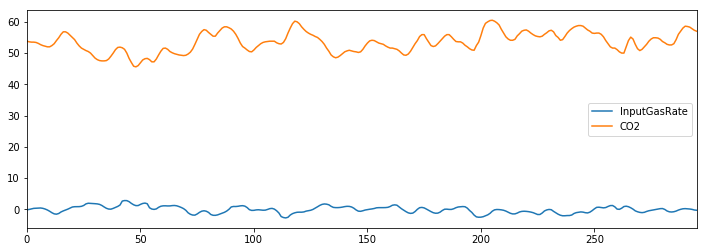

In [20]:
# Visualising
df.plot(figsize=(12,4))